In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [3]:
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [4]:
import pickle
import pandas as pd
import numpy as np

In [5]:
from pymongo import MongoClient
from pprint import pprint

In [6]:
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Load Vectoriser Model from Disk</h2>

In [7]:
# Load the TF model 
filename = 'tf_model.pkl'
tf=pickle.load(open(filename, 'rb'))

In [8]:
# Load the TF Vectoriser 
filename = 'tf_vectorizer.pkl'
tf_vectorizer=pickle.load(open(filename, 'rb'))

In [9]:
feature_names = tf_vectorizer.get_feature_names()

In [10]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [11]:
def create_df(vectorizer,model,no_top_words):
    topic_keywords = show_topics(vectorizer, model, no_top_words)
    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = [str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    return df_topic_keywords

In [12]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [13]:
no_topics = 6
no_features=5000
no_top_words = 14

In [ ]:
<h2>Load the LDA model</h2>

In [14]:
filename = 'lda_model.pkl'
lda=pickle.load(open(filename, 'rb'))

<h2>Display top 50 words of each Topics </h2>

In [15]:
no_top_words = 50
display_topics(lda,feature_names,no_top_words)

Topic 0:
cannabi use cbd research medic marijuana studi drug thc health effect patient oil pain test medicin cannabis product said treatment report treat help cannabinoid new univers percent cancer peopl accord increas opioid contain associ fda risk includ benefit potenti mani high publish brain year alcohol result plant user clinic veteran
Topic 1:
marijuana said pot year polic colorado citi legal california cannabi state sale dispensari tax new store busi offic report recreat accord open arrest say million shop denver retail grow charg local sell counti san month illeg drug home possess oper peopl weed told offici city area public sinc percent case
Topic 2:
marijuana legal drug feder state said law support polici new use cannabi govern nation percent peopl american presid reform bank year trump like enforc war justic gener time public campaign say legalization democrat crimin states attorney group recreat report washington major congress prohibit obama act end make countri unit polit

In [16]:
df_topic_keywords=create_df(tf_vectorizer,lda,no_top_words)
df_topic_keywords

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Topic 0,cannabi,use,cbd,research,medic,marijuana,studi,drug,thc,health,...,high,publish,brain,year,alcohol,result,plant,user,clinic,veteran
Topic 1,marijuana,said,pot,year,polic,colorado,citi,legal,california,cannabi,...,peopl,weed,told,offici,city,area,public,sinc,percent,case
Topic 2,marijuana,legal,drug,feder,state,said,law,support,polici,new,...,major,congress,prohibit,obama,act,end,make,countri,unit,polit
Topic 3,marijuana,state,medic,legal,law,cannabi,allow,use,patient,approv,...,applic,requir,includ,grow,adult,issu,cannabis,sign,governor,support
Topic 4,cannabi,compani,product,market,hemp,industri,canada,million,company,stock,...,trade,aurora,said,expect,farm,cbd,global,billion,facil,quarter
Topic 5,cannabi,like,smoke,weed,time,high,make,peopl,want,way,...,edibl,life,world,live,feel,event,long,consum,differ,infus


<h2>Okay Give some meaningful names to each topics based on 50 words</h2>

In [17]:
Topics = ["Drug Research","Drug Crime","US Drug Policies","Drug Medicines","Drug Products","Consumption"]
df_topic_keywords["Category"]=Topics
df_topic_keywords

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Category
Topic 0,cannabi,use,cbd,research,medic,marijuana,studi,drug,thc,health,...,publish,brain,year,alcohol,result,plant,user,clinic,veteran,Drug Research
Topic 1,marijuana,said,pot,year,polic,colorado,citi,legal,california,cannabi,...,weed,told,offici,city,area,public,sinc,percent,case,Drug Crime
Topic 2,marijuana,legal,drug,feder,state,said,law,support,polici,new,...,congress,prohibit,obama,act,end,make,countri,unit,polit,US Drug Policies
Topic 3,marijuana,state,medic,legal,law,cannabi,allow,use,patient,approv,...,requir,includ,grow,adult,issu,cannabis,sign,governor,support,Drug Medicines
Topic 4,cannabi,compani,product,market,hemp,industri,canada,million,company,stock,...,aurora,said,expect,farm,cbd,global,billion,facil,quarter,Drug Products
Topic 5,cannabi,like,smoke,weed,time,high,make,peopl,want,way,...,life,world,live,feel,event,long,consum,differ,infus,Consumption


<h2>Okay Done now our model is ready. Lets try to predict topics of first 25 documents</h2>

In [28]:
ps = PorterStemmer()
def cleanText(text):
    data = text.split()
    data = [ps.stem(word) for word in data if not word in set(stopwords.words('english'))]
    data = ' '.join(data)
    return data

In [29]:
def predict_topic(new_df):
    text=new_df["Desc"]
    sample_text=cleanText(text)
    dataset=[]
    dataset.append(sample_text)
    mytext = tf_vectorizer.transform(dataset)
    topic_probability_scores = lda.transform(mytext)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:9].values.tolist()
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    new_df["Topic Keywords"]=topic
    new_df["Topic Conribution"]=np.round(topic_probability_scores[0:,np.argmax(topic_probability_scores)],2)
    new_df["Topic"]=infer_topic
    return new_df

In [30]:
def getDBConnection():
    client = MongoClient("localhost:27017")
    db=client.articles
    return db

In [31]:
db=getDBConnection()
articles=db.Articles

In [34]:
myresult = articles.find().limit(25)

In [35]:
dataset=[]
for x in myresult:
    try:
        title=x["title"]
        desc=x["summarization"]
        if(len(desc)==0):
            desc=title
        dataset.append([desc])
    except Exception as e:
        print(e)

In [36]:
new_df = pd.DataFrame(dataset,columns=['Desc'])
new_df=new_df.apply(predict_topic,axis=1)
new_df

,Desc,Topic Keywords,Topic Conribution,Topic
0,Although the legal cannabis market is still ex...,"[compani, product, market, hemp, industri, can...",[0.88],Drug Products
1,"Almost as important, the Farm Bill lets hemp g...","[compani, product, market, hemp, industri, can...",[0.74],Drug Products
2,The company currently has 4.3 million square f...,"[compani, product, market, hemp, industri, can...",[0.91],Drug Products
3,Weekly Cannabis Report: Strong Finish To A Tou...,"[like, smoke, weed, time, high, make, peopl, w...",[0.52],Consumption
4,When California broadly legalized pot on Jan. ...,"[said, pot, year, polic, colorado, citi, legal...",[0.55],Drug Crime
5,"EASTHAMPTON, Mass. - Western Massachusetts' se...","[said, pot, year, polic, colorado, citi, legal...",[0.63],Drug Crime
6,"About a year ago, I made some predictions in t...","[said, pot, year, polic, colorado, citi, legal...",[0.41],Drug Crime
7,When California broadly legalized pot on Jan. ...,"[said, pot, year, polic, colorado, citi, legal...",[0.55],Drug Crime
8,"Delaware, Guam, Kentucky, Massachusetts, Oklah...","[said, pot, year, polic, colorado, citi, legal...",[0.47],Drug Crime
9,Bloomberg) - Aphria Inc. fell 4.3 percent to $...,"[compani, product, market, hemp, industri, can...",[0.8],Drug Products


<h2>Visualisation</h2>

In [25]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4       93.168732  -64.182678       1        1  21.966640
3       -5.345180   -7.261751       2        1  18.014887
1       79.231819   68.842171       3        1  17.385814
2      -29.039085 -118.543732       4        1  16.917089
5     -118.502274  -19.116266       5        1  13.225047
0      -51.587906   96.693436       6        1  12.490523, topic_info=     Category           Freq       Term          Total  loglift  logprob
2747  Default   81099.000000      medic   81099.000000  30.0000  30.0000
2688  Default  183361.000000  marijuana  183361.000000  29.0000  29.0000
4264  Default   88460.000000      state   88460.000000  28.0000  28.0000
887   Default   33019.000000    compani   33019.000000  27.0000  27.0000
673   Default   28268.000000        cbd   28268.000000  26.0000  26.0000
...       ...            ...        ...            ...      ...      ...
2203   Topic6    3728.838079    increas    9584.733122   1.1361  -5.5178
3266   Topic6    4128.330663    percent   16542.010111   0.6922  -5.4160
2974   Topic6    4292.768262        new   48243.302970  -0.3391  -5.3770
3262   Topic6    3857.114950      peopl   23575.544656   0.2699  -5.4840
31     Topic6    3737.008899     accord   17535.279283   0.5343  -5.5156

[478 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
31        1  0.125632  accord
31        2  0.130366  accord
31        3  0.384368  accord
31        4  0.144737  accord
31        5  0.001768  accord
...     ...       ...     ...
4984      2  0.125243    year
4984      3  0.348516    year
4984      4  0.151506    year
4984      5  0.099561    year
4984      6  0.074486    year

[1017 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 6, 1])

In [26]:
# Create Document — Topic Matrix
lda_output = lda.transform(tf)
# column names
topicnames = ["Topic" + str(i+1) for i in range(lda.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(lda_output.shape[0])]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic+1

<h2>Display Total Number Of Documents By Dominent Topic</h2>

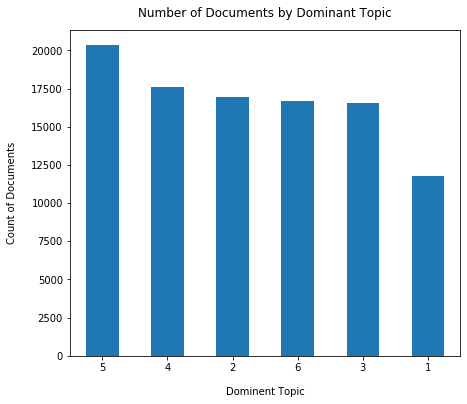

In [27]:
df_document_topic['dominant_topic'].value_counts().plot(kind='bar',figsize=(7, 6), rot=0);
plt.xlabel("Dominent Topic", labelpad=14)
plt.ylabel("Count of Documents", labelpad=14)
plt.title("Number of Documents by Dominant Topic", y=1.02);